**Task 1**

The first task involves preprocessing the CrisisLexT26 dataset to make it analysis-ready.
All tweets will be cleaned by removing URLs, mentions, and emojis, while maintaining
punctuation and emotional markers like exclamation marks. Lowercasing and tokenization
using BERT tokenizer will ensure uniformity. A detailed text statistics report will highlight
average tweet length, vocabulary richness, and noise ratio. This step ensures that emotional
and empathetic cues are preserved rather than filtered out.

In [1]:
import sys
import os
from collections import Counter
from pathlib import Path

main = Path.cwd() / "CrisisLexT26"
output_csv = "combined_cleaned_tweets.csv"

#loading csv files
import glob
import pandas as pd
files = glob.glob(os.path.join(main, "**", "*tweets_labeled*.csv"), recursive=True)

sets = []
for f in files:
    s = pd.read_csv(f, encoding="utf-8", lineterminator="\n")
    s.columns = s.columns.str.lower().str.strip()

    event = os.path.basename(os.path.dirname(f))
    if "tweet id" in s.columns:
        tweet_id_col = "tweet id"
    elif "tweet_id" in s.columns:
        tweet_id_col = "tweet_id"
    else:
        tweet_id_col = None

    if tweet_id_col is not None and "tweet text" in s.columns:
        subset = pd.DataFrame({
            "event": event,
            "tweet_id": s[tweet_id_col],     
            "tweet_text_raw": s["tweet text"].astype(str)
        })
        sets.append(subset)

all_sets = pd.concat(sets, ignore_index=True)

#removing noise
import re
import regex as re2 

URL_RE     = re.compile(r"https?://\S+|www\.\S+", flags=re.IGNORECASE)
MENTION_RE = re.compile(r"@\w+", flags=re.IGNORECASE)
CONTROL_RE = re.compile(r"[\x00-\x1F\x7F]+")
HASHTAG_RE = re.compile(r"#(\w+)", flags=re.UNICODE)
ALPHA_RE   = re.compile(r"[A-Za-zÀ-ÖØ-öø-ÿ]+")
EMOJI_RE   = re2.compile(r"[\p{Emoji_Presentation}\p{Emoji}\u200d\ufe0f]+")

def clean_text(text: str) -> str:
    """Remove URLs, mentions, emojis, and control chars.
       Keep punctuation, lowercase text, and preserve hashtag words."""
    if not isinstance(text, str):
        return ""
    s = URL_RE.sub(" ", text)
    s = MENTION_RE.sub(" ", s)
    s = EMOJI_RE.sub(" ", s)
    s = CONTROL_RE.sub(" ", s)
    s = HASHTAG_RE.sub(r"\1", s)  
    s = re.sub(r"\s+", " ", s).strip()
    return s.lower()


all_sets["clean_text"] = all_sets["tweet_text_raw"].apply(clean_text)
all_sets["word_tokens"] = all_sets["clean_text"].str.split()

def is_noise(tokens):
    alpha = []
    for t in tokens:
        if ALPHA_RE.search(t): 
            alpha.append(t) 
    if len(alpha) == 0:
        return True
    else:
        return False

all_sets["is_noise"] = all_sets["word_tokens"].apply(is_noise)

#tokenization
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def bert_tokenize(text):
    if not text: 
        return []
    return tokenizer.tokenize(text)

all_sets["bert_tokens"] = all_sets["clean_text"].apply(bert_tokenize)
all_sets[["event", "tweet_id", "clean_text"]].to_csv(output_csv, index=False)

#statistics report + saving final csv
n_tweets = len(all_sets)
avg_bert_len = all_sets["bert_tokens"].apply(len).mean()
noise_ratio = all_sets["is_noise"].mean()

from itertools import chain
bert_tokens = list(chain.from_iterable(all_sets["bert_tokens"]))
vocab_size_bert = len(set(bert_tokens))
total_bert_tokens = len(bert_tokens)
if total_bert_tokens > 0:
    ttr_bert = vocab_size_bert / total_bert_tokens
else:
    ttr_bert = 0.0

all_sets[["event", "tweet_id", "clean_text"]].to_csv(output_csv, index=False)

print(f"Tweets processed: {n_tweets:,}")
print(f"Average length: {avg_bert_len:.2f}")
print(f"Vocabulary richness: {ttr_bert:.3f}")
print(f"Noise ratio: {noise_ratio:.4%}")
print(f"Saved cleaned dataset → {os.path.abspath(output_csv)}")


Tweets processed: 27,933
Average length: 23.85
Vocabulary richness: 0.022
Noise ratio: 0.2327%
Saved cleaned dataset → C:\UNI-4\NLPaTM 25\projectT\combined_cleaned_tweets.csv


**Task 2**

Next, the tweets will be separated by crisis event (e.g., Haiti earthquake, Boston
bombing, Alberta floods). Each subset will retain timestamps, allowing event-specific linguistic
trend analysis. This stratification helps compare how emotional tone differs between natural
and human-induced disasters and lays the foundation for empathy and sentiment
contextualization later.


In [2]:
df_clean = pd.read_csv("combined_cleaned_tweets.csv")
df_clean["tweet_id"] = df_clean["tweet_id"].astype(str)

ent_rows = []
ent_files = glob.glob(os.path.join(main, "**", "*entire*period*.csv"), recursive=True)

def find_id(cols):
    cols = [c.lower().strip() for c in cols]
    for cand in ("tweet id"):
        if cand in cols: 
            return cand
    for c in cols:
        if "id" in c: 
            return c
    return None

def find_time(cols):
    cols = [c.lower().strip() for c in cols]
    for cand in ("timestamp"):
        if cand in cols: 
            return cand
    for c in cols:
        if "time" in c or "date" in c: 
            return c
    return None

for ef in ent_files:
    e = pd.read_csv(ef, encoding="utf-8", on_bad_lines="skip", lineterminator="\n")
    e.columns = e.columns.str.lower().str.strip()
    id_col = find_id(e.columns)
    tm_col = find_time(e.columns)
    e = e[[id_col, tm_col]].rename(columns={id_col: "tweet_id", tm_col: "timestamp"})
    ent_rows.append(e)

ent_all = pd.concat(ent_rows, ignore_index=True)
ent_all["tweet_id"] = ent_all["tweet_id"].astype(str)
ent_all["timestamp"] = pd.to_datetime(ent_all["timestamp"], utc=True)

ent_all = ent_all.sort_values(by=["tweet_id", "timestamp"], na_position="last")
ent_all = ent_all.drop_duplicates(subset="tweet_id", keep="first")

merged = df_clean.merge(ent_all, on="tweet_id", how="left")
merged.to_csv("combined_cleaned_with_timestamps.csv", index=False)

#this can be removed later
with_ts = merged["timestamp"].notna().sum()
print(f"Cleaned rows:           {len(df_clean):,}")
print(f"Timestamps matched:     {with_ts:,} ({with_ts/len(merged):.2%})")
print(f"Saved → {os.path.abspath('combined_cleaned_with_timestamps.csv')}")

C:\Users\timop\AppData\Local\Temp\ipykernel_1600\4241143566.py:37: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ent_all["timestamp"] = pd.to_datetime(ent_all["timestamp"], utc=True)


Cleaned rows:           27,933
Timestamps matched:     27,933 (100.00%)
Saved → C:\UNI-4\NLPaTM 25\projectT\combined_cleaned_with_timestamps.csv


**Task 3** 

In this stage, each tweet's sentiment will be classified as positive, neutral, or negative
using two models: VADER (for lexicon-based interpretability), SentiStrength, and RoBERTabased sentiment analysis (for contextual understanding). The sentiment intensity score will be
normalized to highlight crisis peaks, for instance, identifying days where negative sentiment
spikes correspond with on-ground impact escalation.

In [3]:
from tqdm import tqdm #for tracking
tqdm.pandas()

df = pd.read_csv("combined_cleaned_with_timestamps.csv", parse_dates=["timestamp"])
print(f"Loaded {len(df):,} tweets with timestamps")

#VADER
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download("vader_lexicon", quiet=True)

vader = SentimentIntensityAnalyzer()
df["vader_score"] = df["clean_text"].progress_apply(lambda t: vader.polarity_scores(str(t))["compound"])

def vader_label(x):
    if x >= 0.05:
        return "positive"
    elif x <= -0.05:
        return "negative"
    else:
        return "neutral"

df["vader_label"] = df["vader_score"].apply(vader_label)


#RoBERTa
import torch
from transformers import pipeline

# HF now blocks torch.load() on <torch 2.6 due to CVE-2025-32434, and the
# Cardiff sentiment model only publishes pytorch_model.bin on the Hub.
# To use the same weights locally we load a safetensors dump (shared in repo)
# via AutoConfig + load_state_dict instead of calling from_pretrained().

from safetensors.torch import load_file
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification

device = 0 if torch.cuda.is_available() else -1

# roberta_sa = pipeline(
#     "sentiment-analysis",
#     model="cardiffnlp/twitter-roberta-base-sentiment",
#     device=device,
#     model_kwargs={"use_safetensors": True}
# )

model_id = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_id)
config = AutoConfig.from_pretrained(model_id)
state_dict = load_file("model.safetensors")
model = AutoModelForSequenceClassification.from_config(config)
model.load_state_dict(state_dict)

roberta_sa = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    device=device,
)


def roberta_sentiment(text):
    try:
        result = roberta_sa(text[:512])[0]
        return pd.Series([result["label"].lower(), result["score"]])
    except Exception:
        return pd.Series([None, None])

df[["roberta_label", "roberta_score"]] = df["clean_text"].progress_apply(roberta_sentiment)

label_map = {
    "label_0": "negative",
    "label_1": "neutral",
    "label_2": "positive"
}
df["roberta_label"] = df["roberta_label"].map(label_map)

#normalization
import numpy as np

def normalize(col):
    vals = df[col].to_numpy(dtype=float)
    min_v, max_v = np.nanmin(vals), np.nanmax(vals)
    return (vals - min_v) / (max_v - min_v) if max_v != min_v else np.zeros_like(vals)

df["vader_norm"] = normalize("vader_score")
df["roberta_norm"] = normalize("roberta_score")

#saving the file + checking
print("\nVADER label counts:")
print(df["vader_label"].value_counts())

print("\nRoBERTa label counts:")
print(df["roberta_label"].value_counts())

df.to_csv("tweets_with_sentiment.csv", index=False)
print(f"saved {'tweets_with_sentiment.csv'}")
#print(df[["event", "timestamp", "clean_text", "vader_label", "roberta_label"]].head())


Loaded 27,933 tweets with timestamps


100%|██████████████████████████████████████████████████████████████████████████| 27933/27933 [00:04<00:00, 6261.92it/s]
Device set to use cuda:0
100%|████████████████████████████████████████████████████████████████████████████| 27933/27933 [06:24<00:00, 72.65it/s]


saved tweets_with_sentiment.csv


**Task 4** 

Moving beyond polarity, this task maps tweets into Plutchik’s eight basic emotions (joy,
sadness, fear, anger, surprise, trust, disgust, anticipation). A fine-tuned emotion classification
model like GoEmotions-RoBERTa will be used. The output reveals emotional distribution across
different crises, for instance, more fear during earthquakes versus more anger during industrial
accidents.

In [4]:
from transformers import AutoConfig
from math import isfinite

df = pd.read_csv("tweets_with_sentiment.csv", parse_dates=["timestamp"])

#loading the model
emo_model_name = "SamLowe/roberta-base-go_emotions"
emo_cfg = AutoConfig.from_pretrained(emo_model_name)
go_id2label = emo_cfg.id2label

device = 0 if torch.cuda.is_available() else -1

roberta_emo = pipeline(
    "text-classification",
    model=emo_model_name,
    tokenizer=emo_model_name,
    top_k=None, 
    truncation=True,
    device = device
)

#GoEmotions to Plutchik conversion
go_labels = [go_id2label[i] for i in range(len(go_id2label))]

#admiration, amusement, anger, annoyance, approval, caring, confusion, curiosity, desire, 
#disappointment, disapproval, disgust, embarrassment, excitement, fear, gratitude, grief,
#joy, love, nervousness, optimism, pride, realization, relief, remorse, sadness, surprise, neutral
Plutchik_groups = {
    "joy":         ["joy", "amusement", "excitement", "optimism", "pride", "love", "gratitude", "relief"],
    "sadness":     ["sadness", "grief", "disappointment", "remorse", "embarrassment"],
    "fear":        ["fear", "nervousness"],
    "anger":       ["anger", "annoyance", "disapproval"],
    "surprise":    ["surprise", "realization", "confusion"],
    "trust":       ["admiration", "approval", "caring", "love", "gratitude"],
    "disgust":     ["disgust"],
    "anticipation":["curiosity", "desire", "optimism", "excitement"], 
}
Neutral_label = "neutral"

label_to_idx = {lab: i for i, lab in enumerate(go_labels)}

def goemotions_to_plutchik(prob_vector):
    scores = {}
    total = 0.0
    for p_lab, members in Plutchik_groups.items():
        s = 0.0
        for m in members:
            idx = label_to_idx.get(m)
            if idx is not None and 0 <= idx < len(prob_vector):
                v = prob_vector[idx]
                if isfinite(v):
                    s += float(v)
        scores[p_lab] = s
        total += s
    if total > 0:
        for k in scores:
            scores[k] /= total
    return scores

texts = df["clean_text"].fillna("").astype(str).tolist()
batch_size = 64 #change if too slow

all_plutchik_rows = []
for start in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
    batch = texts[start:start+batch_size]
    batch_out = roberta_emo(batch)

    for item in batch_out:
        vec = [0.0]*len(go_labels)
        for d in item:
            lab = d["label"].lower()
            if lab.startswith("label_"):
                try:
                    idx = int(lab.split("_")[-1])
                    lab = go_id2label[idx]
                except Exception:
                    pass
            if lab in label_to_idx:
                vec[label_to_idx[lab]] = float(d["score"])
        pl = goemotions_to_plutchik(vec)
        top_e = max(pl.items(), key=lambda kv: kv[1])[0] if pl else None
        row = {"plutchik_top": top_e}
        row.update({f"plutchik_{k}": v for k, v in pl.items()})
        all_plutchik_rows.append(row)

emo_df = pd.DataFrame(all_plutchik_rows)
df = pd.concat([df.reset_index(drop=True), emo_df.reset_index(drop=True)], axis=1)

df.to_csv("tweets_with_emotions.csv", index=False)
print(f"saved {'tweets_with_emotions.csv'}")

by_event = (
    df.dropna(subset=["plutchik_top"])
      .groupby(["event", "plutchik_top"])
      .size()
      .reset_index(name="count")
)
top1_per_event = (
    by_event.sort_values(["event", "count"], ascending=[True, False])
             .groupby("event")
             .head(1)
             .reset_index(drop=True)
)

print("\nTop 1 emotion per event:")
print(top1_per_event)

top1_per_event.to_csv("event_top_emotions.csv", index=False)
print("\nSaved summary at event_top_emotions.csv")


Device set to use cuda:0
Processing batches: 100%|████████████████████████████████████████████████████████████| 437/437 [05:51<00:00,  1.24it/s]


saved tweets_with_emotions.csv

Top 1 emotion per event:
                            event plutchik_top  count
0         2012_Colorado_wildfires        trust    641
1      2012_Costa_Rica_earthquake        trust    847
2       2012_Guatemala_earthquake        trust    655
3          2012_Italy_earthquakes        trust    679
4         2012_Philipinnes_floods        trust    632
5              2012_Typhoon_Pablo        trust    546
6         2012_Venezuela_refinery        trust    598
7             2013_Alberta_floods        trust    547
8         2013_Australia_bushfire        trust    633
9           2013_Bohol_earthquake        trust    547
10           2013_Boston_bombings        trust    478
11     2013_Brazil_nightclub_fire        trust    454
12           2013_Colorado_floods        trust    468
13  2013_Glasgow_helicopter_crash      sadness    504
14      2013_LA_airport_shootings        trust    420
15  2013_Lac_Megantic_train_crash        trust    474
16             2013_Manil

**Task 5**

Empathic language often drives social support in crises. This task trains or fine-tunes a
transformer on empathy detection using the Empathic Reactions Dataset as an auxiliary source,
applying zero-shot classification on CrisisLexT26 tweets. The goal is to estimate empathy scores
identifying compassionate vs. detached tones, to understand the public’s collective concern and
willingness to help.

In [5]:
df = pd.read_csv("tweets_with_emotions.csv", parse_dates=["timestamp"])
print(f"Loaded {len(df):,} tweets for empathy detection")

device = 0 if torch.cuda.is_available() else -1

print("\nLoading zero-shot empathy classifier")
empathy_clf = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",
    device=device 
)

#defining empathy-related candidate labels
candidate_labels = ["compassionate", "detached", "neutral"]

#applying zero-shot inference with batching
texts = df["clean_text"].fillna("").astype(str).tolist()
batch_size = 128
results = []

#calculating empathy score
for start in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
    batch = texts[start:start+batch_size]
    outputs = empathy_clf(batch, candidate_labels, multi_label=False)
    for res in outputs:
        top_label = res["labels"][0].lower()
        top_score = float(res["scores"][0])

        empathic_score = 0.0
        for label, score in zip(res["labels"], res["scores"]):
            if label.lower() == "compassionate":
                empathic_score += 1.0 * score
            elif label.lower() == "neutral":
                empathic_score += 0.5 * score
            elif label.lower() == "detached":
                empathic_score += 0.0 * score

        results.append({
            "empathy_label": top_label,
            "empathy_score": empathic_score
        })

empathy_df = pd.DataFrame(results)
df = pd.concat([df.reset_index(drop=True), empathy_df.reset_index(drop=True)], axis=1)

df.to_csv("tweets_with_empathy.csv", index=False)
print(f"\n saved tweets_with_empathy.csv")

#summary
avg_score = df["empathy_score"].mean()
top_empathy_events = (
    df.groupby("event")["empathy_score"]
      .mean()
      .sort_values(ascending=False)
      .head(10)
)
print(f"\nAverage empathy score (overall): {avg_score:.3f}")
print("\nTop 10 events by empathy level:")
print(top_empathy_events.reset_index())


Loaded 27,933 tweets for empathy detection

Loading zero-shot empathy classifier


Device set to use cuda:0
Processing batches: 100%|████████████████████████████████████████████████████████████| 219/219 [47:18<00:00, 12.96s/it]



 saved tweets_with_empathy.csv

Average empathy score (overall): 0.335

Top 10 events by empathy level:
                        event  empathy_score
0     2012_Philipinnes_floods       0.563148
1        2013_Typhoon_Yolanda       0.505660
2       2013_Bohol_earthquake       0.477986
3          2013_Manila_floods       0.457379
4         2013_Alberta_floods       0.431044
5  2013_Brazil_nightclub_fire       0.382730
6        2013_Sardinia_floods       0.376717
7          2012_Typhoon_Pablo       0.360426
8      2012_Italy_earthquakes       0.360033
9        2013_Colorado_floods       0.356920


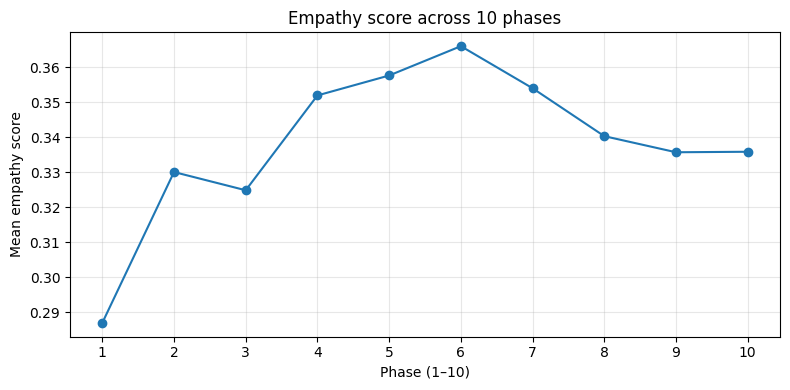

In [23]:
#task 5 visualization
df = pd.read_csv("tweets_with_empathy.csv", parse_dates=["timestamp"])

phase_records = []
for event, event_df in df.groupby("event"):
    event_df = event_df.sort_values("timestamp").reset_index(drop=True)
    if len(event_df) < 10:
        continue  # skip events too small for 10 bins
    event_df["phase"] = pd.qcut(event_df.index, q=10, labels=False, duplicates="drop") + 1
    phase_records.append(
    event_df.groupby("phase")["empathy_score"]
            .mean()
            .to_frame(name="empathy_score")
            .assign(event=event)
            .reset_index()
)


empathy_phases = (
    pd.concat(phase_records, ignore_index=True)
      .groupby("phase")["empathy_score"]
      .mean()
      .reset_index()
)

empathy_phases.to_csv("temporal_empathy_trend.csv", index=False)

plt.figure(figsize=(8, 4))
plt.plot(empathy_phases["phase"], empathy_phases["empathy_score"],
         marker="o", color="#1f77b4")
plt.title("Empathy score across 10 phases")
plt.xlabel("Phase (1–10)")
plt.ylabel("Mean empathy score")
plt.xticks(range(1, 11))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


**Task 6**

Empathic tweets tend to use personal pronouns, modal verbs, and direct appeals. This
task uses LIWC or spaCy-based linguistic feature extraction to analyze syntactic and stylistic
markers. Metrics like lexical diversity, average sentence complexity, and sentiment-bearing
adjectives are computed to show how linguistic simplicity rises during emergencies, enhancing
accessibility and relatability.

In [6]:
import spacy

tqdm.pandas()
nlp = spacy.load("en_core_web_sm")

df = pd.read_csv("tweets_with_empathy.csv", parse_dates=["timestamp"])

vader = SentimentIntensityAnalyzer()
vader_words = vader.lexicon.keys()

def extract_features(text):
    doc = nlp(text)
    tokens = [t for t in doc if t.is_alpha]
    words = [t.text.lower() for t in tokens]

    pronouns = [t.text.lower() for t in doc if t.pos_ == "PRON"]
    modals = [t.text.lower() for t in doc if t.lemma_ in ["can","could","should","would","must","might","may","will","shall"]]
    adjectives = [t.text.lower() for t in doc if t.pos_ == "ADJ"]

    sentiment_adj = [a for a in adjectives if a in vader_words]

    ttr = len(set(words)) / len(words) if words else 0
    avg_sent_len = sum(len(sent) for sent in doc.sents) / len(list(doc.sents)) if len(list(doc.sents)) > 0 else 0

    return pd.Series({
        "lexical_diversity": ttr,
        "avg_sent_len": avg_sent_len,
        "pronoun_ratio": len(pronouns) / len(words) if words else 0,
        "modal_ratio": len(modals) / len(words) if words else 0,
        "adj_ratio": len(adjectives) / len(words) if words else 0,
        "sentiment_adj_ratio": len(sentiment_adj) / len(words) if words else 0
    })


ling_df = df["clean_text"].fillna("").astype(str).progress_apply(extract_features)
df = pd.concat([df, ling_df], axis=1)

df.to_csv("tweets_with_linguistics.csv", index=False)
print("saved tweets_with_linguistics.csv")


100%|███████████████████████████████████████████████████████████████████████████| 27933/27933 [04:08<00:00, 112.21it/s]


saved tweets_with_linguistics.csv


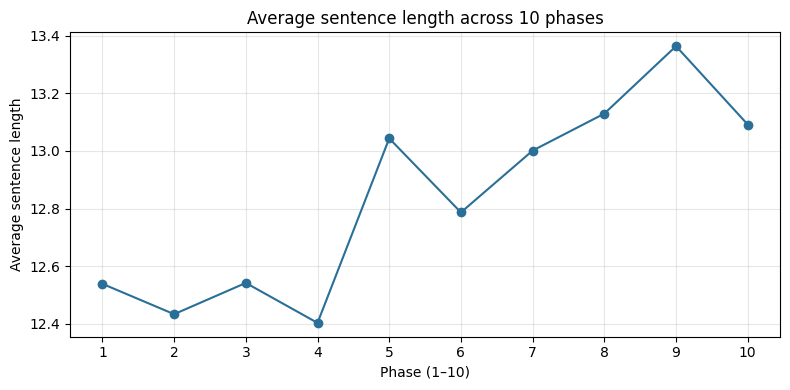

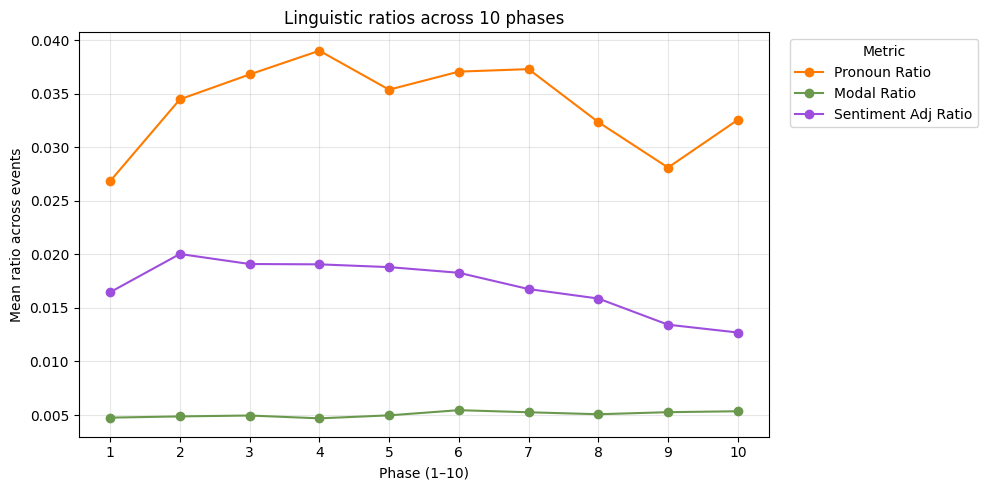

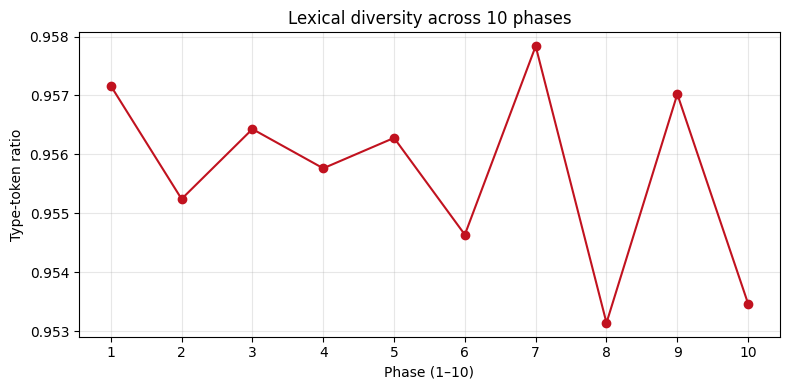

In [19]:
#task 6 visualization 
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("tweets_with_linguistics.csv", parse_dates=["timestamp"])
ratio_metrics = ["pronoun_ratio", "modal_ratio", "sentiment_adj_ratio"]
all_metrics = ["lexical_diversity", "avg_sent_len", *ratio_metrics]

phase_records = []
for event, event_df in df.groupby("event"):
    event_df = event_df.sort_values("timestamp").reset_index(drop=True)
    if len(event_df) < 10:
        continue
    event_df["phase"] = pd.qcut(event_df.index, q=10, labels=False, duplicates="drop") + 1
    phase_records.append(
        event_df.groupby("phase")[all_metrics]
                .mean()
                .assign(event=event)
                .reset_index()
    )

phase_stats = (
    pd.concat(phase_records, ignore_index=True)
      .groupby("phase")[all_metrics]
      .mean()
      .reset_index()
)

phase_stats.to_csv("temporal_linguistic_trends.csv", index=False)

#average sentence length
plt.figure(figsize=(8, 4))
plt.plot(phase_stats["phase"], phase_stats["avg_sent_len"], marker="o", color="#2a6f97")
plt.title("Average sentence length across 10 phases")
plt.xlabel("Phase (1–10)")
plt.ylabel("Average sentence length")
plt.xticks(range(1, 11))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#pronoun, modal, sent-adj ratios
plt.figure(figsize=(10, 5))
for col, color in zip(ratio_metrics, ["#ff7b00", "#6a994e", "#9d4edd"]):
    plt.plot(phase_stats["phase"], phase_stats[col], marker="o", label=col.replace("_", " ").title(), color=color)

plt.title("Linguistic ratios across 10 phases")
plt.xlabel("Phase (1–10)")
plt.ylabel("Mean ratio across events")
plt.xticks(range(1, 11))
plt.grid(True, alpha=0.3)
plt.legend(title="Metric", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

#lexical diversity
plt.figure(figsize=(8, 4))
plt.plot(phase_stats["phase"], phase_stats["lexical_diversity"], marker="o", color="#c1121f")
plt.title("Lexical diversity across 10 phases")
plt.xlabel("Phase (1–10)")
plt.ylabel("Type-token ratio")
plt.xticks(range(1, 11))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


**Task 7**

Using BERTopic (based on Sentence-BERT embeddings + HDBSCAN clustering), thematic
patterns will be extracted from emotionally charged tweets. Topics such as “help requests,”
“solidarity,” or “infrastructure loss” are automatically discovered and labeled. Each topic will be
annotated with its dominant emotion (from Task 4) to map emotional context to thematic
focus.

In [7]:
# import pandas as pd
# import torch
#imports above only used for testing, can be removed when running all the code

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

df = pd.read_csv("tweets_with_linguistics.csv", parse_dates=["timestamp"])
print(f"Loaded {len(df):,} tweets with full features from file.")

texts = df["clean_text"].astype(str).tolist()
print(f"Using {len(texts):,} tweets for topic modeling.")

#loading BERT
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\nUsing device: {device}")
embedding_model = SentenceTransformer("all-MiniLM-L6-v2", device=device)

topic_model = BERTopic(
    embedding_model=embedding_model,
    verbose=True,
    calculate_probabilities=True,
    nr_topics="auto"
)

print("\nTraining BERTopic model")
topics, probs = topic_model.fit_transform(texts)

#merging
df = df.reset_index(drop=True)
df["topic"] = topics

topic_emotions = (
    df.groupby("topic")["plutchik_top"]
    .agg(lambda x: x.value_counts().idxmax())
    .reset_index(name="dominant_emotion")
)

topic_info = topic_model.get_topic_info()
topic_info.rename(columns={"Topic": "topic"}, inplace=True)
topic_info = topic_info.merge(topic_emotions, on="topic", how="left")

#results
topic_info.to_csv("topic_emotion_summary.csv", index=False)
df.to_csv("tweets_with_topics.csv", index=False)

print(" saved topic_emotion_summary.csv")
print(" saved tweets_with_topics.csv")


Loaded 27,933 tweets with full features from file.
Using 27,933 tweets for topic modeling.

Using device: cuda


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2025-11-13 17:23:05,502 - BERTopic - Embedding - Transforming documents to embeddings.



Training BERTopic model


Batches:   0%|          | 0/873 [00:00<?, ?it/s]

2025-11-13 17:23:59,710 - BERTopic - Embedding - Completed ✓
2025-11-13 17:23:59,711 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-13 17:24:33,743 - BERTopic - Dimensionality - Completed ✓
2025-11-13 17:24:33,746 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-13 17:26:34,408 - BERTopic - Cluster - Completed ✓
2025-11-13 17:26:34,409 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-11-13 17:26:35,086 - BERTopic - Representation - Completed ✓
2025-11-13 17:26:35,087 - BERTopic - Topic reduction - Reducing number of topics
2025-11-13 17:26:35,275 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-13 17:26:35,697 - BERTopic - Representation - Completed ✓
2025-11-13 17:26:35,700 - BERTopic - Topic reduction - Reduced number of topics from 385 to 205


 saved topic_emotion_summary.csv
 saved tweets_with_topics.csv


**Task 8**

This task aligns tweet timestamps with the progression of each disaster event. A
temporal aggregation is performed to visualize emotion transitions — e.g., fear dominating the
onset phase, followed by sadness during aftermath. Such temporal emotion trajectories help
identify psychological phases of collective response and can inform mental-health-aware early
warning systems.


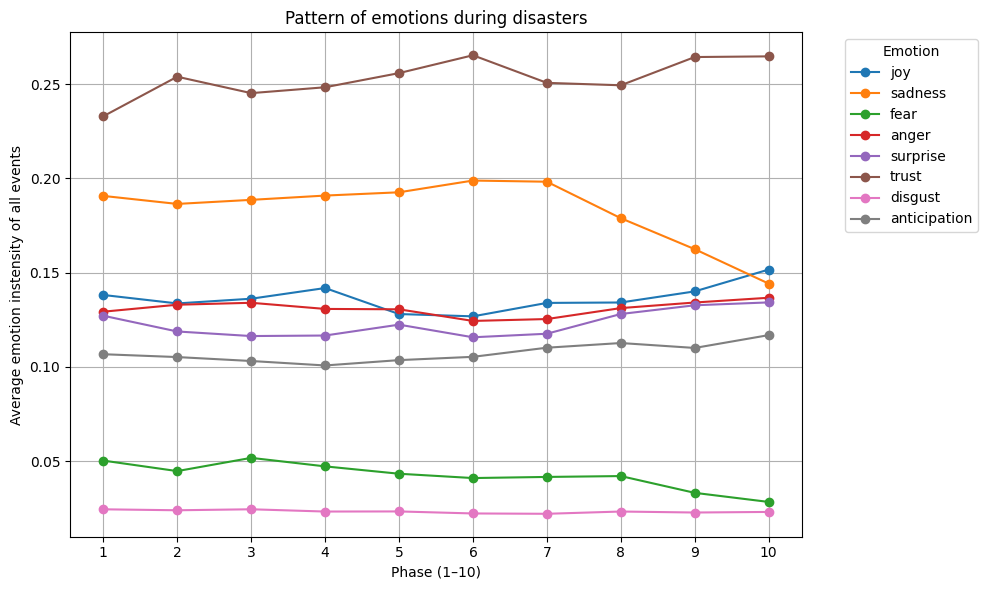

In [28]:
df = pd.read_csv("tweets_with_linguistics.csv", parse_dates=["timestamp"])
events = df["event"].unique()

records = []

# for event in events:
#     event_df = df[df["event"] == event].sort_values("timestamp")
#     event_df["phase"] = pd.qcut(event_df.index, q=10, labels=False) + 1    

#new filtering step
for event in events:
    event_df = (
        df[df["event"] == event].sort_values("timestamp").reset_index(drop=True)
    )
    if len(event_df) < 10:
        continue  # optional guard for tiny events
    event_df["phase"] = pd.qcut(
        event_df.index,
        q=10,
        labels=False,
        duplicates="drop"
    ) + 1


#finding emotions by phase
    emotion_by_phase = (
        event_df.groupby("phase")[
            ["plutchik_joy", "plutchik_sadness", "plutchik_fear", "plutchik_anger",
             "plutchik_surprise", "plutchik_trust", "plutchik_disgust", "plutchik_anticipation"]
        ]
        .mean()
        .reset_index()
    )
    emotion_by_phase["event"] = event
    records.append(emotion_by_phase)

all_emotions = pd.concat(records)

#finding frequency of each emotion per phase
emotion_freq = (
    all_emotions.groupby("phase")[
        ["plutchik_joy", "plutchik_sadness", "plutchik_fear", "plutchik_anger",
         "plutchik_surprise", "plutchik_trust", "plutchik_disgust", "plutchik_anticipation"]
    ]
    .mean()
    .reset_index()
)


emotion_freq.to_csv("temporal_emotion_frequencies.csv", index=False)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for emotion in emotion_freq.columns[1:]:
    label = emotion.replace("plutchik_", "")
    plt.plot(emotion_freq["phase"], emotion_freq[emotion], marker="o", label=label)

plt.title("Pattern of emotions during disasters")
plt.xlabel("Phase (1–10)")
plt.ylabel("Average emotion instensity of all events")
plt.xticks(range(1, 11))
plt.legend(title="Emotion", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
#task 9
#треклятый мурад хочет, чтобы мы где-то достали инфу о лайках и ретвитах, при том что их НЕТ В ЕБАНОМ ДАТАСЕТЕ. Эту парашу невозможно сделать

**Task 10**

A transfer learning experiment tests whether a model trained to classify emotion on
one disaster generalizes to another. For example, a classifier trained on “flood” events is tested
on “earthquake” tweets. The cross-domain F1-score quantifies linguistic variability and
universality in emotional expression during crises.

Loaded 27,933 labeled tweets across 26 events.

Available events:
['2012_Colorado_wildfires', '2012_Costa_Rica_earthquake', '2012_Guatemala_earthquake', '2012_Italy_earthquakes', '2012_Philipinnes_floods', '2012_Typhoon_Pablo', '2012_Venezuela_refinery', '2013_Alberta_floods', '2013_Australia_bushfire', '2013_Bohol_earthquake', '2013_Boston_bombings', '2013_Brazil_nightclub_fire', '2013_Colorado_floods', '2013_Glasgow_helicopter_crash', '2013_Lac_Megantic_train_crash', '2013_LA_airport_shootings', '2013_Manila_floods', '2013_NY_train_crash', '2013_Queensland_floods', '2013_Russia_meteor', '2013_Sardinia_floods', '2013_Savar_building_collapse', '2013_Singapore_haze', '2013_Spain_train_crash', '2013_Typhoon_Yolanda', '2013_West_Texas_explosion']

Training on 6,200 tweets from 6 flood events
Testing on 4,462 tweets from 4 earthquake events

cross-domain emotion classification results
              precision    recall  f1-score   support

       anger      0.358     0.261     0.302       5

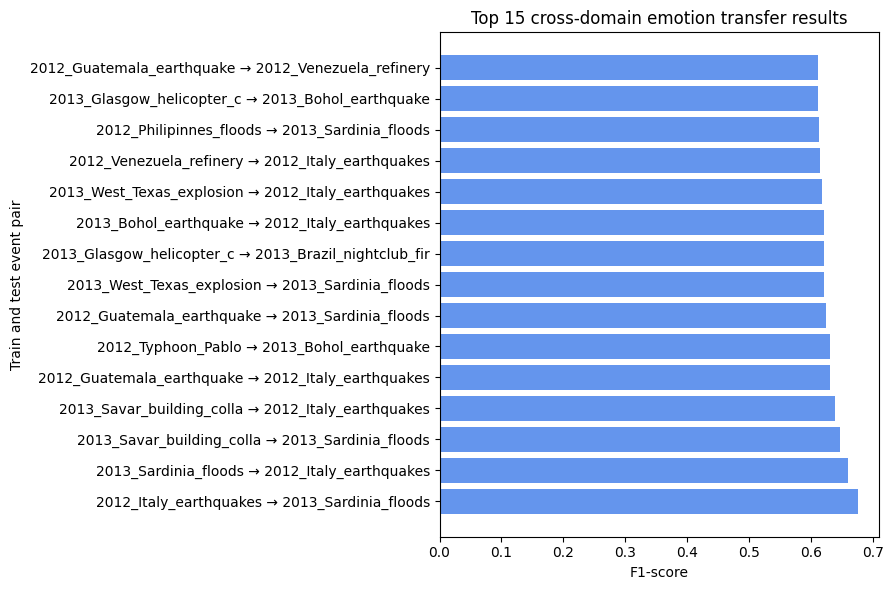

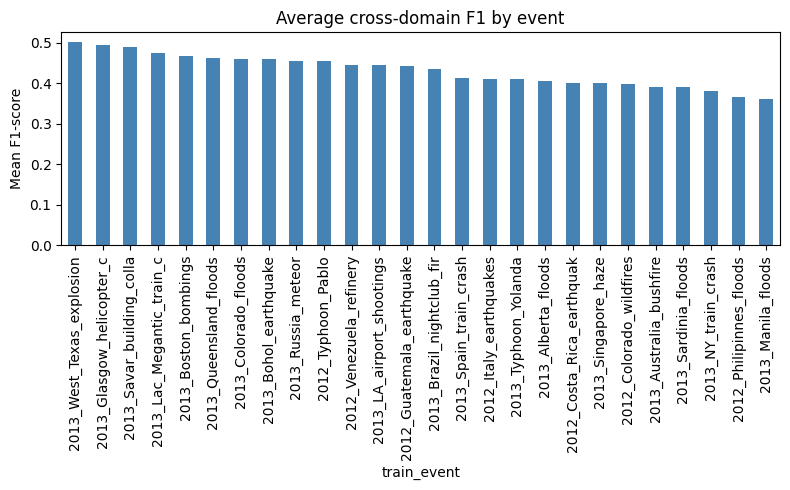

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from itertools import permutations

df = pd.read_csv("tweets_with_emotions.csv")
df = df[["event", "clean_text", "plutchik_top"]].dropna()
print(f"Loaded {len(df):,} labeled tweets across {df['event'].nunique()} events.")

#checking the events
events = df["event"].unique().tolist()
print("\nAvailable events:")
print(events)

#flood to earthquake transfer
train_events = [e for e in events if "flood" in e.lower()]
test_events = [e for e in events if "earthquake" in e.lower()]

train_df = df[df["event"].isin(train_events)]
test_df = df[df["event"].isin(test_events)]

print(f"\nTraining on {len(train_df):,} tweets from {len(train_events)} flood events")
print(f"Testing on {len(test_df):,} tweets from {len(test_events)} earthquake events")

#vectorization
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train = vectorizer.fit_transform(train_df["clean_text"].astype(str))
y_train = train_df["plutchik_top"].astype(str)

X_test = vectorizer.transform(test_df["clean_text"].astype(str))
y_test = test_df["plutchik_top"].astype(str)

#classifier
clf = LogisticRegression(max_iter=200, solver="liblinear", class_weight="balanced")
clf.fit(X_train, y_train)

#flood to earthquake results
y_pred = clf.predict(X_test)
f1 = f1_score(y_test, y_pred, average="weighted")

print("\ncross-domain emotion classification results")
print(classification_report(y_test, y_pred, digits=3))
print(f"\nF1-score (flood to earthquake): {f1:.3f}")

#all event pairs
pairs = []
f1_scores = []

for train_ev, test_ev in permutations(events, 2):
    tr_df = df[df["event"] == train_ev]
    ts_df = df[df["event"] == test_ev]
    
    Xtr = vectorizer.fit_transform(tr_df["clean_text"].astype(str))
    ytr = tr_df["plutchik_top"].astype(str)
    Xts = vectorizer.transform(ts_df["clean_text"].astype(str))
    yts = ts_df["plutchik_top"].astype(str)
    
    clf.fit(Xtr, ytr)
    ypred = clf.predict(Xts)
    f1_pair = f1_score(yts, ypred, average="weighted")
    
    pairs.append(f"{train_ev[:25]} → {test_ev[:25]}")
    f1_scores.append(f1_pair)

f1_df = pd.DataFrame({"pair": pairs, "f1": f1_scores})
f1_df.to_csv("cross_domain_f1_scores.csv", index=False)
print("\nSaved results to cross_domain_f1_scores.csv")

#results
pairs_sorted = sorted(zip(pairs, f1_scores), key=lambda x: x[1], reverse=True)
pairs_top, f1_top = zip(*pairs_sorted[:15])

plt.figure(figsize=(9, 6))
plt.barh(pairs_top, f1_top, color="cornflowerblue")
plt.xlabel("F1-score")
plt.ylabel("Train and test event pair")
plt.title("Top 15 cross-domain emotion transfer results")
plt.tight_layout()
plt.show()

f1_df["train_event"] = f1_df["pair"].apply(lambda x: x.split("→")[0].strip())
f1_mean = f1_df.groupby("train_event")["f1"].mean().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
f1_mean.plot(kind="bar", color="steelblue")
plt.title("Average cross-domain F1 by event")
plt.ylabel("Mean F1-score")
plt.tight_layout()
plt.show()
